In [1]:
%matplotlib inline
import numpy as np
from scipy import ndimage
from PIL import Image 
import matplotlib.pyplot as plt

# Histogramas de Luminancia

## Ejercicios

1. Generar el Histograma de Luminancia para una imagen dada. Generarlo utilizando:

   1. 10
   2. 20
   3. 50

In [2]:
image = np.array(Image.open('data/ecocentro.jpg'))

In [3]:
from image_manip import normalize

def generate_luminance_histogram(image, n_intervals=[10]):
    # Generate Y values for image
    
    def reduce(pixel):
        r, g, b = pixel
        return .299*r + .587*g + .114*b

    def get_y_values(image):
        """Return y values from an image
        
        Returns an array, where each value is the
        Y value for each pixel, where the Y value
        for the (i,j) pixel is in the position
        w*i + j with w equal to the width of the image
        """
        normalized_image = normalize(image)
        return np.array(np.apply_along_axis(func1d=reduce, axis=2, arr=normalized_image).flat)
    
    def plot_histogram(image, values, n_intervals):
        
        fig, ax = plt.subplots(nrows=1, ncols=len(n_intervals)+1, figsize=(30,8))
    
        for index, interval in enumerate(n_intervals):
            heights, bins = np.histogram(values, bins=interval, range=(0,1))
            percent = [(h/number_of_pixels)*100 for h in heights]
            i = index+1

            ax[i].bar(bins[:-1], percent,width=1/interval, align="edge", edgecolor="black")
            
            ax[i].set_ylabel("Porcentaje de Píxeles (%)")
            ax[i].set_xlabel("Valor de luminancia")
            ax[i].set_ylim(0,1)
            ax[i].set_xlim(0,1)
            ax[i].set_yticks(np.arange(0,110, step=10))
            ax[i].grid(axis='y')
        
        ax[0].imshow(image)
        plt.show()
    
        
    y_values = get_y_values(image)
    number_of_pixels = len(y_values)
        
    plot_histogram(image, y_values, n_intervals)
    
def generate_luminance_histogram_from_path(image_path, n_intervals):
    generate_luminance_histogram(np.array(Image.open(image_path)), n_intervals)

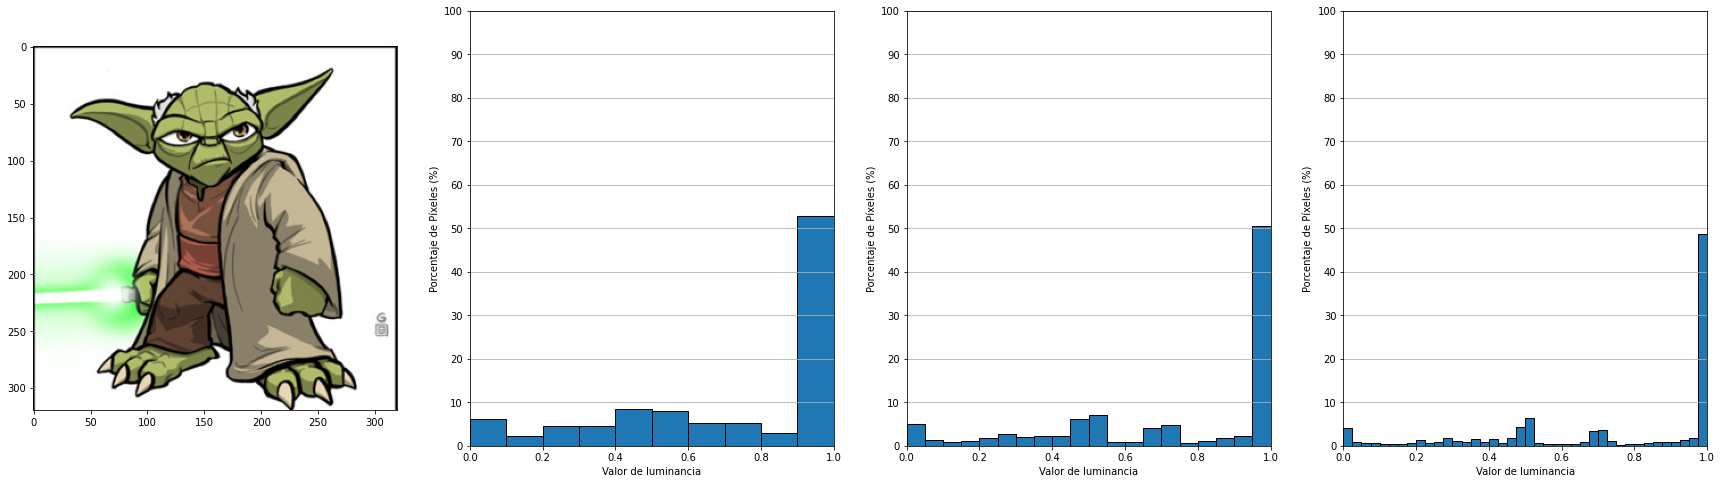

In [4]:
generate_luminance_histogram_from_path('data/yoda.jpg',n_intervals=[10,20,40])

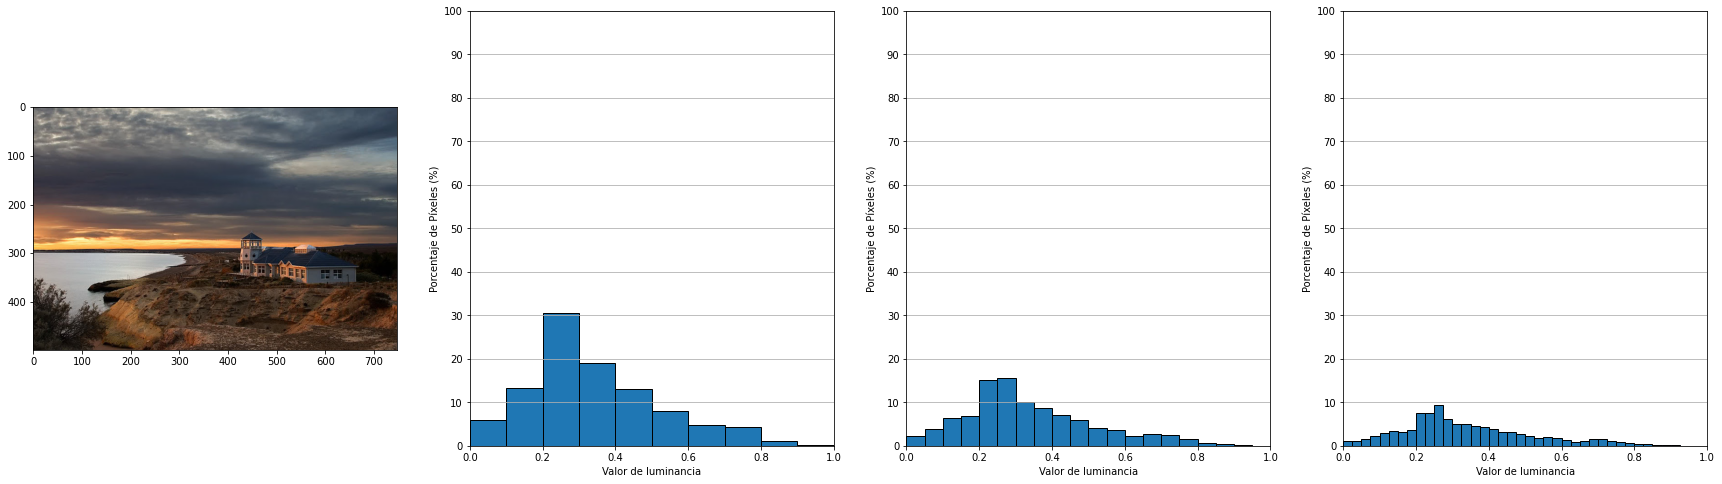

In [5]:
generate_luminance_histogram_from_path('data/ecocentro.jpg',n_intervals=[10,20,40])

# Manipular $\alpha$ de una imagen ya oscura

In [5]:
from image_manip import apply_yiq_transformation



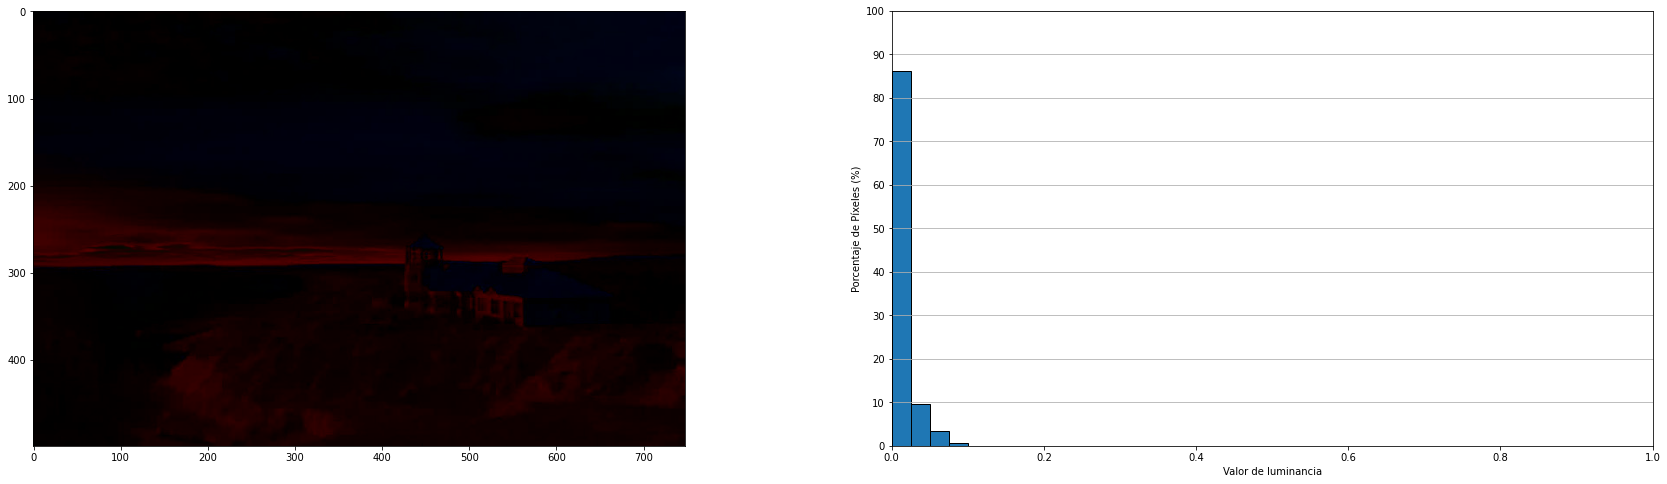

In [8]:
generate_luminance_histogram(ecocentro_dark, n_intervals=[40])

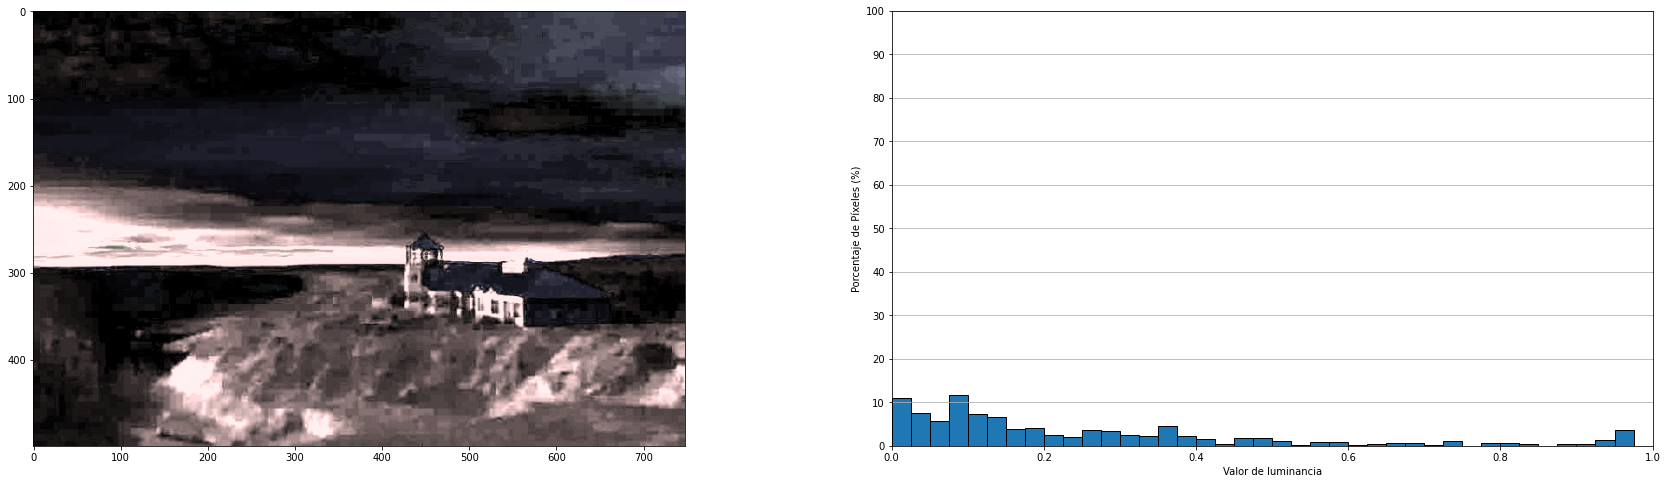

In [9]:
generate_luminance_histogram(ecocentro_dark_alpha_twenty, n_intervals=[40])

# Manipular $\alpha$ de una imagen muy clara

In [10]:
ecocentro_bright = apply_yiq_transformation(np.array(Image.open("data/ecocentro.jpg")), alpha=10) # Alpha multiplicado por 10
ecocentro_bright_alpha_1_over_10 = apply_yiq_transformation(ecocentro_bright, alpha=.1)

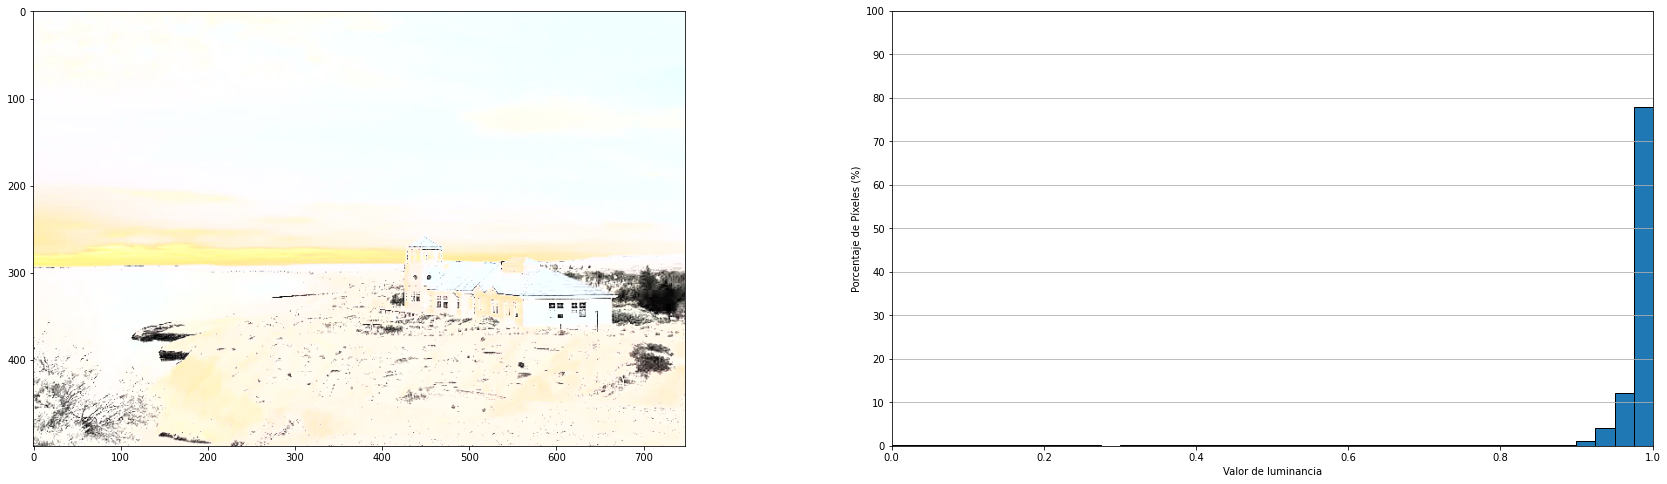

In [11]:
generate_luminance_histogram(ecocentro_bright, n_intervals=[40])

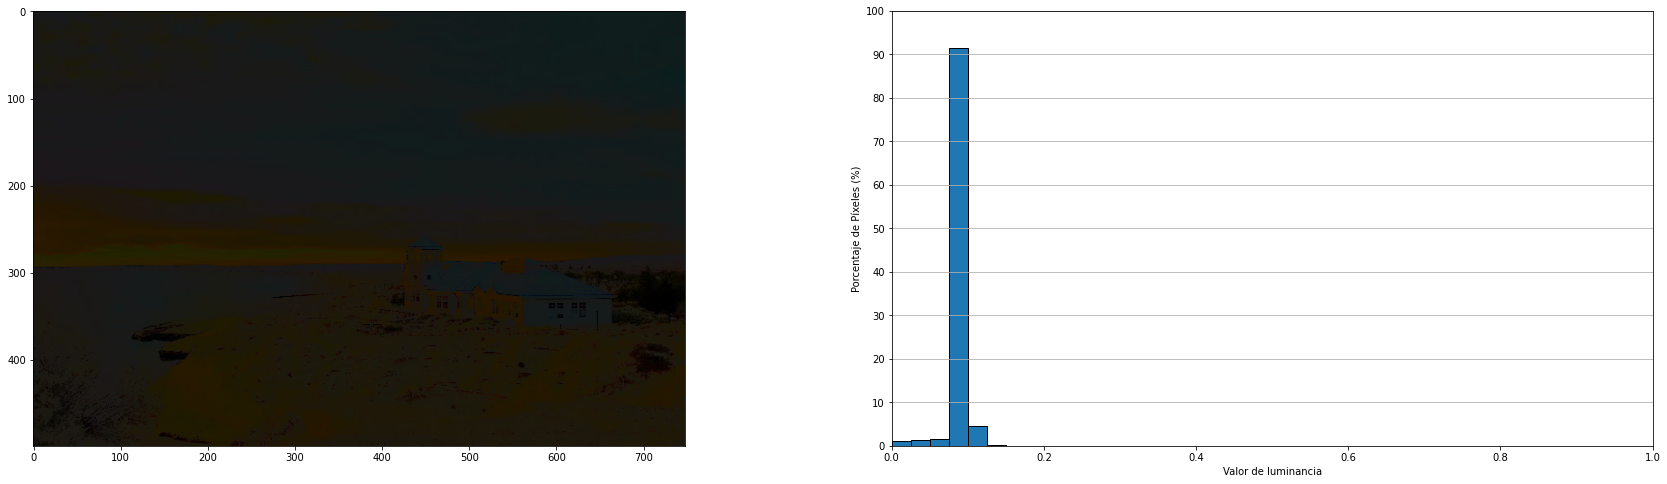

In [12]:
generate_luminance_histogram(ecocentro_bright_alpha_1_over_10, n_intervals=[40]) 

# Aplicar una función no lineal para manipular la imagen

In [9]:
from image_manip import transform_to_yiq, transform_to_rgb, normalize, denormalize

def apply_y_function_transformation(image, function=lambda pixel: pixel):
    """Applies a transformation to an image according to alpha and beta"""
    # Normalize the given image
    norm_img = normalize(image)
    
    # Convert to YIQ
    yiq_image = np.apply_along_axis(
        func1d=transform_to_yiq,
        axis=2,
        arr=norm_img
    )
    
    # Apply transformation
    yiq_prime_image = np.apply_along_axis(
        func1d=function
        ,axis=2,
        arr=yiq_image
    )
    
    # Deconvert to RGB
    rgb_prime_image = np.apply_along_axis(
        func1d=transform_to_rgb,
        axis=2,
        arr=yiq_prime_image
    )
    
    # Return denormalized image
    return denormalize(rgb_prime_image)

In [8]:
import math

def apply_sqrt(pixel):
    y, i,q = pixel
    
    y = math.pow(y, 1/2)
    
    if y > 1:
        y=1
        
    return [y,i,q]

def apply_square(pixel):
    y, i,q = pixel
    
    y = math.pow(y, 2)
    
    if y > 1:
        y=1
        
    return [y,i,q]


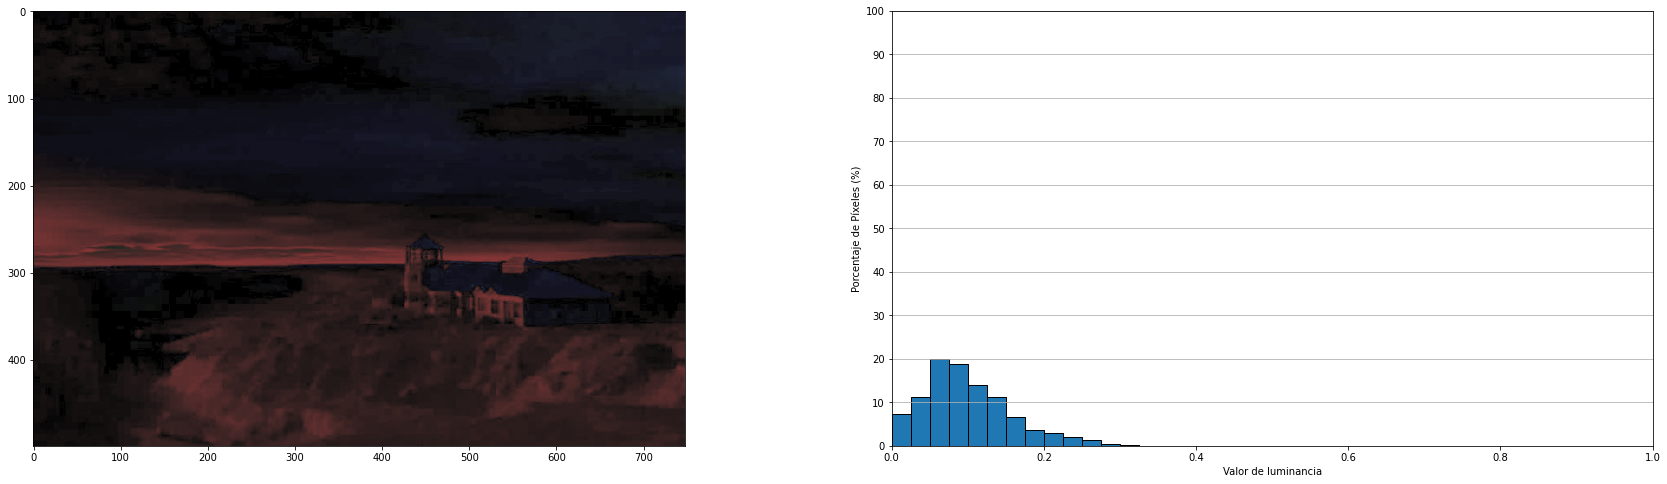

In [15]:
ecocentro_dark_sqrt = apply_y_function_transformation(ecocentro_dark, apply_sqrt)
generate_luminance_histogram(ecocentro_dark_sqrt, n_intervals=[40]) 

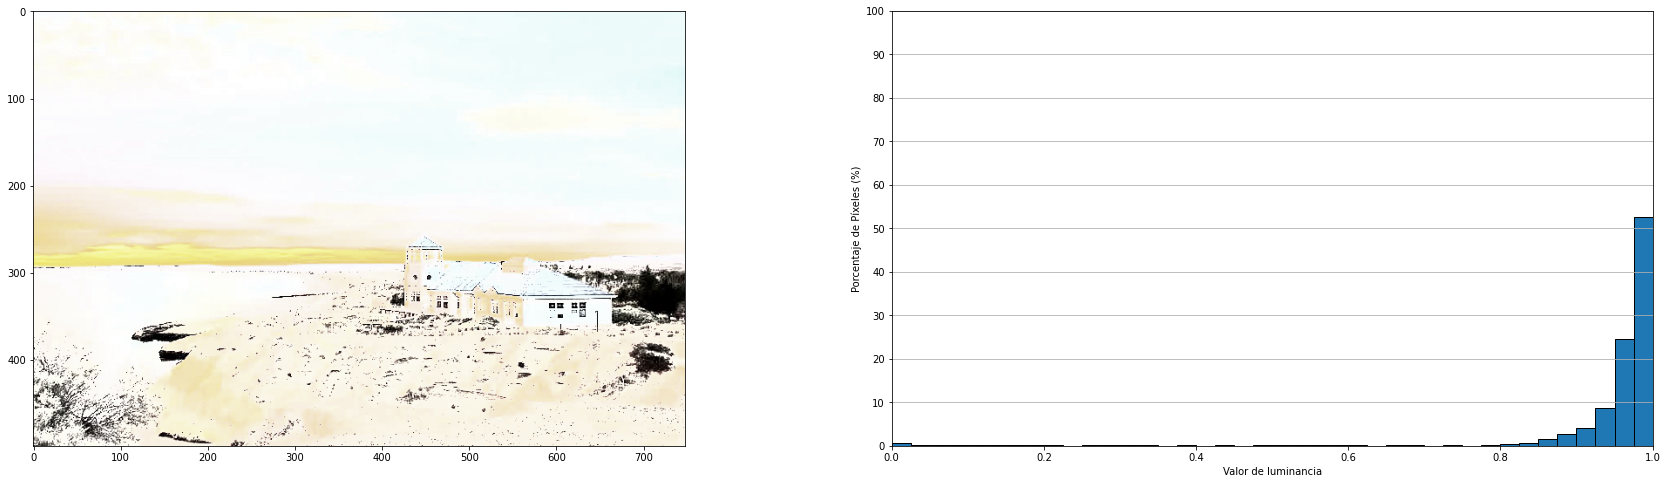

In [16]:
ecocentro_bright_square = apply_y_function_transformation(ecocentro_bright, apply_square)
generate_luminance_histogram(ecocentro_bright_square, n_intervals=[40]) 

# Aplicar función lineal de a trozos

In [7]:
def linear_function_from_two_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    
    m = (y2-y1) / (x2-x1)
    b = y1 - (m * x1)
    
    def f(x):
        return (m * x) + b
    return f
    
def apply_lineal_by_parts(lower, upper):
    
    positive = lower <= upper
    
    points = []
    if positive:
        points += [(lower, 0), (upper, 1)]
    else:
        points += [(lower, 1), (upper, 0)]
        
    def _apply(y):
        if positive and y > upper:
            return 1
        elif positive and y < lower:
            return 0
        elif not positive and y > upper:
            return 0
        elif not positive and y < lower:
            return 1
        else:
            return linear_function_from_two_points((lower, 0), (upper,1))(y)

    return _apply

def apply_lineal_by_parts_to_pixel(lower, upper):
    def _apply(pixel):
        y,i,q = pixel
        return [apply_lineal_by_parts(lower, upper)(y),i,q]
    return _apply

In [6]:
ecocentro_bright_by_parts = apply_y_function_transformation(ecocentro_bright, apply_lineal_by_parts_to_pixel(.99, .7))
generate_luminance_histogram(ecocentro_bright_by_parts, n_intervals=[40]) 

NameError: name 'apply_y_function_transformation' is not defined

In [10]:
ecocentro = np.array(Image.open("data/ecocentro.jpg"))

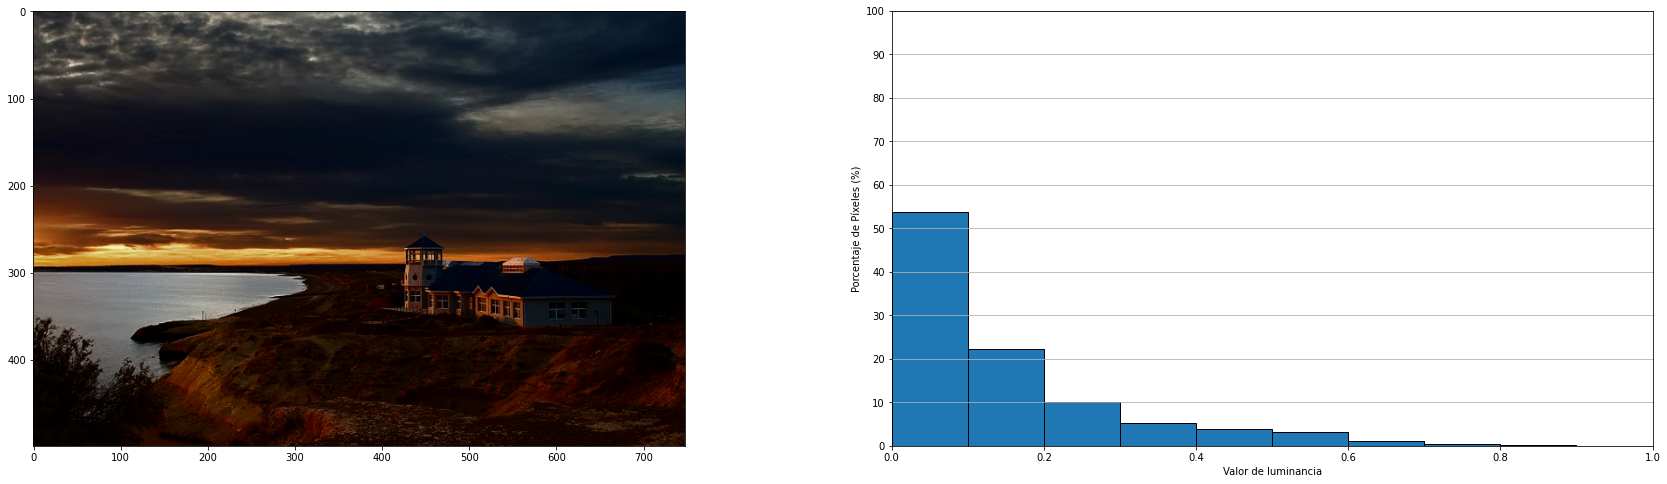

In [13]:
eco_square = apply_y_function_transformation(image=ecocentro, function=apply_square)
generate_luminance_histogram(image=eco_square)

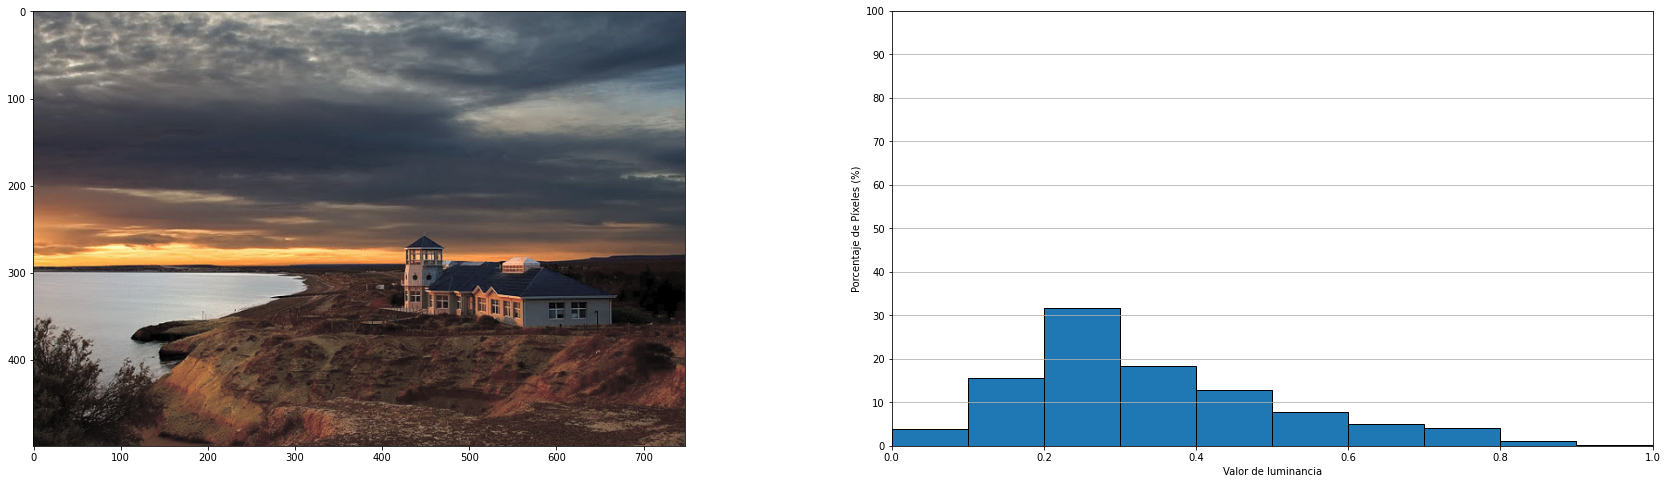

In [14]:
eco_root_square = apply_y_function_transformation(image=eco_square, function=apply_sqrt)
generate_luminance_histogram(image=eco_root_square)